# Turing Target Practice

## Model

In [14]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [15]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [16]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [17]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [18]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [19]:
target = TuringTarget(stat_model);

In [20]:
eps=0.01
L=sqrt(2)*0.01
mchmc = Sampler(eps, L, integrator="MN")

Sampler(Settings(Random.MersenneTwister(0), 0.2, 0, 1000, 10, "MN"), Hyperparameters{Float64}(0.01, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Minimal_norm)

In [21]:
samples_mchmc = Sample(mchmc, target, 10000; monitor_energy=true)

Row,Ω,E,logp
,Any,Any,Any
1,"[0.261648, 0.431459]",0.0,-43.662
2,"[0.261648, 0.431459]",-0.00162113,-40.5343
3,"[0.265682, 0.440563]",3.12437,-37.4978
4,"[0.267142, 0.450394]",3.03376,-34.515
5,"[0.2711, 0.45954]",2.98165,-31.5862
6,"[0.274456, 0.468954]",2.92794,-28.7715
7,"[0.275982, 0.478787]",2.90496,-27.0694
8,"[0.271891, 0.486432]",1.79294,-24.339
9,"[0.274915, 0.495964]",2.73041,-21.7468


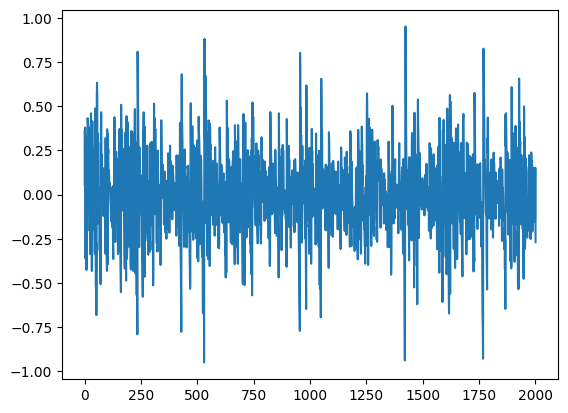

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7feb596e3790>

In [22]:
plt.plot(samples_mchmc.E[8000:end])

In [23]:
mean(samples_mchmc.E[8000:end])

0.0019379515042576825

In [24]:
std(samples_mchmc.E[8000:end])/target.d

0.11966806675452017

In [25]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

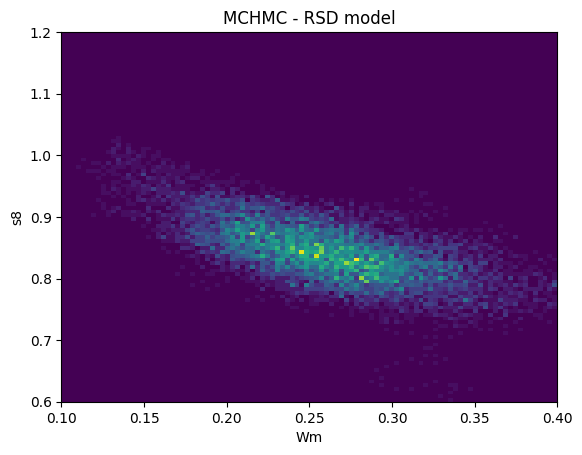

In [26]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [102]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.43 seconds
Compute duration  = 2.43 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2516    0.0598     0.0006    0.0012   2773.9550    0.9999    ⋯
          σ8    0.8527    0.0543     0.0005    0.0011   2590.8094    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [103]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

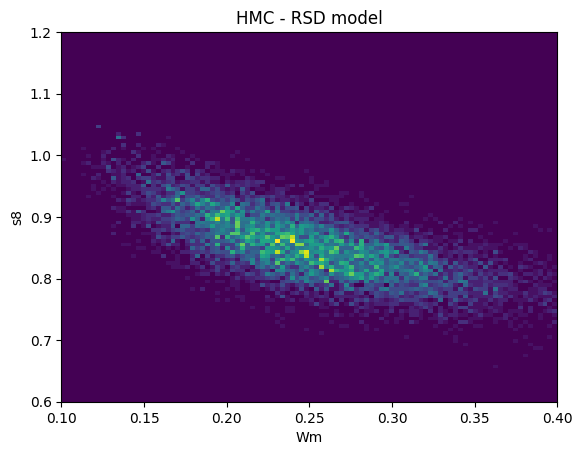

In [104]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");

## Self-tuning

In [33]:
mchmc = Sampler(0.0, 0.0; varE_wanted=0.2)
println(string("L = ", mchmc.hyperparameters.L, ", eps = ", mchmc.hyperparameters.eps))
# This should start self-tuning

L = 0.0, eps = 0.0


In [34]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

Self-tuning hyperparameters
Hyperparameter tuning (first stage)
VarE: NaN
eps: 0.5
VarE: 30.417818460825806
eps: 0.25
VarE: 25.70220487914008
eps: 0.125
VarE: 10.30172594088469
eps: 0.0625
VarE: 3.707282556082978
eps: 0.03125
VarE: 1.338599829636089
eps: 0.015625
VarE: 0.586279418681679
eps: 0.0078125
VarE: 0.24320893415347655
eps: 0.00390625
VarE: 0.10626353497709835
eps: 0.001953125


LoadError: MethodError: [0mCannot `convert` an object of type [92mtypeof(Base.eps)[39m[0m to an object of type [91mFloat64[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mtwiceprecision.jl:273[24m[39m
[0m  convert(::Type{T}, [91m::AbstractChar[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mchar.jl:185[24m[39m
[0m  convert(::Type{T}, [91m::CartesianIndex{1}[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:127[24m[39m
[0m  ...
